# Data Preparation

## 1 Setup

In [1]:
from scipy import stats
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
import time
from typing import Union
import numpy as np
import pandas as pd
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
import seaborn as sns
from idstools._config import load_config
from idstools._objects import Target
from idstools.preparation import DataPreparation
from idstools.optimization import ModelOptimization
%matplotlib inline

Funktionen zur Visualisierung der Performance unserer Modelle.

In [2]:
def performance_measures(y_true, y_pred) -> tuple:
    """
    Calculate R2 and MAE
    
    Args:
        y_true: array-like
        True values
        y_pred: array-like
        Predicted values
        
    Returns:
        r2: float
        R2 score
        mae: float
        Mean Absolute Error
    """
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"R2: {r2:.2f}")
    print(f"MAE: {mae:.2f}")
    return r2, mae

In [3]:
def actual_vs_predicted(true_v, pred_v) -> None:
    """
    Plot actual vs. predicted values

    Args:
        true_v: array-like
        True values
        pred_v: array-like
        Predicted values

    Returns:
        None
    """
    data = {"Actual": true_v, "Predicted": pred_v}
    df = pd.DataFrame(data)

    # Create a lineplot with Seaborn
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(10, 6))

    sns.lineplot(data=df, markers=False)

    plt.title("Actual vs. Predicted Values")
    plt.xlabel("Data Points")
    plt.ylabel("Values")

    plt.show()

Diese Klasse wird verwendet um eigene Funktionen in die Pipeline zu integrieren.

In [4]:
class CustomTransformer(BaseEstimator, TransformerMixin):
    """This class is used to apply custom transformations."""
    def __init__(self, function, config: dict = {}):
        self.function = function
        self.config = config

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = self.function(X, **self.config) 
        return X

In [5]:
def select_numeric(df: pd.DataFrame) -> pd.DataFrame:
    """
    This function selects the numeric columns from a DataFrame.
    
    Args:
        df: DataFrame
        The input DataFrame
    
    Returns:
        DataFrame
        A DataFrame with only numeric columns
    """
    df = df.select_dtypes(include=[np.number])
        
    return df

## 2 Import der Daten

Wir laden unsere beiden Datensätze in ```DataFrames```.

In [6]:
train_data = pd.read_csv(f"../data/BikeRentalDaily_train.csv", sep=";", index_col=0)
test_data = pd.read_csv(f"../data/BikeRentalDaily_test.csv", sep=";", index_col=0)

Die Summe der beiden Spalten ```casual``` und ```registered``` ergibt den Wert von ```cnt```, diese sind in der Beschreibung des Datensatzes zudem als Labels beschrieben, daher werden sie ebenfalls entfernt.

In [7]:
features = train_data.columns.drop(["cnt", "casual", "registered"])

## 3 Minimal Preprocessing and Baseline Linear Regression Model

Um unsere Modelle unabhängig von den Testdaten valdieren zu können, splitten wir die ```train_data``` Daten in train und validate.

Dieser Schritt wird vor jeder erneuten Validierung druchgeführt.

In [8]:
X_train, X_validate, y_train, y_validate = train_test_split(train_data[features], train_data["cnt"], test_size=0.2, random_state=42)

Wir definieren die ```baseline_model``` Pipeline mit einem ```LinearRegression``` Modell.

Damit wir unser Baseline Modell trainieren können, müssen wir Vorverarbeitungsschritte durchführen. Diese werden in der ```minimal_preprocessing``` Pipeline definiert.

Zum einen entfernen wir alle nicht numerischen Spalten aus den Daten.

Zum anderen werden alle ```NaN``` Werte unter Anwendung des ```SimpleImputer``` durch den jeweiligen Mittlewert aufgefüllt.

In [9]:
baseline_model = Pipeline([("baseline_model", LinearRegression())])

numeric_values = CustomTransformer(function=select_numeric)

minimal_preprocessing = Pipeline([
    ("numeric_values", numeric_values),
    ("imputer", SimpleImputer(strategy="mean"))])

Für die erste Iteration des Preprocessing erzeugen wir eine ```minimal_pipeline``` welche die beiden zuvor erzeugten Pipelines miteinander kombiniert.

In [10]:
minimal_pipe = Pipeline([("preprocessing", minimal_preprocessing), ("baseline_model", baseline_model)])

Die einzelnen Schritte der erzeugten Pipeline werden nacheinander ausgeführt und das Modell wird auf dem verarbeiteten Datensatz trainiert.

In [11]:
minimal_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('numeric_values',
                                  CustomTransformer(function=<function select_numeric at 0x7fa3eadf7060>)),
                                 ('imputer', SimpleImputer())])),
                ('baseline_model',
                 Pipeline(steps=[('baseline_model', LinearRegression())]))])

Im Anschluss nutzten wir die Validierungsdaten um das Modell damit zu evaluieren.

In [12]:
y_pred = minimal_pipe.predict(X_validate)

Die beiden zu Beginn definierten Funktionen geben zum einen die ```performance_measures``` und die Darstellung der ```acutual_vs_predicted``` Werte aus.

In [13]:
_, _ = performance_measures(y_validate, y_pred)

R2: 0.22
MAE: 1322.88


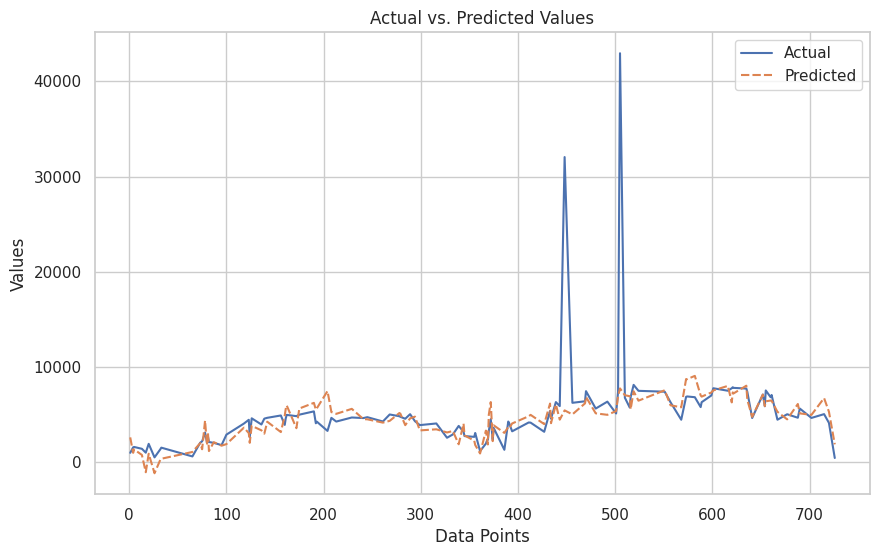

In [14]:
actual_vs_predicted(y_validate, y_pred)

Aus dem Diagramm wird ersichtlich, dass unser ```baseline_model``` aufgrund der Ausreißer im Label ```cnt``` noch Schwierigkeiten bei der Vorhersage hat.

## 4 Missing Value Handling

In [15]:
X_train, X_validate, y_train, y_validate = train_test_split(train_data[features], train_data["cnt"], test_size=0.2, random_state=42)

<Axes: >

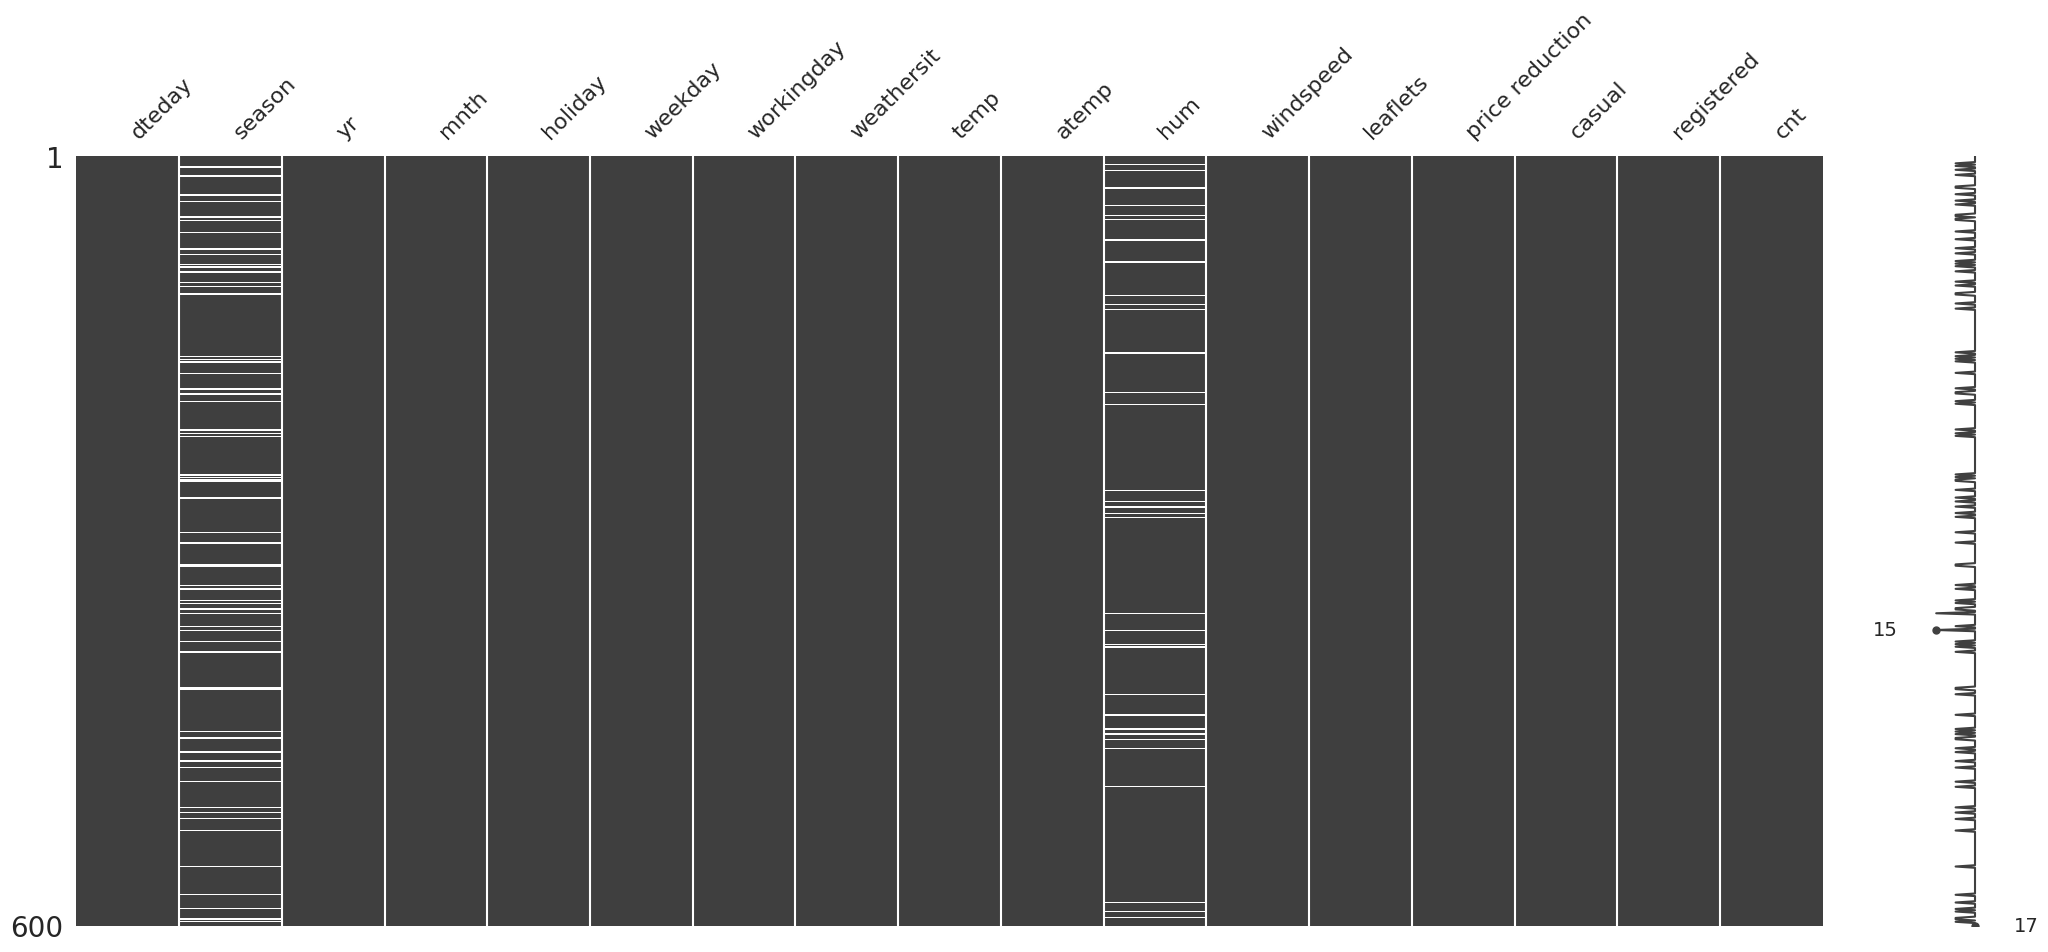

In [16]:
msno.matrix(train_data)

Wie wir bereits in Task 1 erarbeitet haben, weisen die Spalten `season` und `hum` fehlende Werte auf. 

Im `minimal_preprocessing` werden alle `NaN` Werte mit durch den `SimpleImputer` mit `mean` aufgefüllt.

Nun sollen die fehlenden Werte in der Spalte `season` anhand des vorliegenden Datums in der entsprechenden Zeile aufgefüllt werden. 

`impute_season` bestimmt die Jahreszeit anhand eines Datums im Format `"%d.%m.%y"`. 

Diese liest den Tag des entsprechenden Datums aus und weist diesen der dafür entsprechenden Season zu.

Es gibt vier fest definierte Zeitpunkte für den Beginn jeder Jahreszeit (Frühling, Sommer, Herbst, Winter).

Diese Zeitpunkte sind auf den 20. März, 20. Juni, 20. September und 20. Dezember festgelegt.

Damit wir die entsprechende Season anhand des Datums bestimmen können, müssen wir die Werte der Spalte `dteday` zuvor in `datetime` Objekte umwandeln. 

Dafür nutzen wir die `feature_to_datetime` Funktion, welche der preprocessing Pipeline als CustomTransformer mitgegeben wird.

In [17]:
def feature_to_datetime(df: pd.DataFrame, target: str, date_format: str = "%d.%m.%Y") -> pd.DataFrame:
    """
    Convert the feature to datetime.
    
    Args:
        df: pd.DataFrame: The DataFrame to be transformed.
        target: str: The feature to be transformed.
        date_format: str: The format of the date.

    Returns:
        pd.DataFrame: The transformed DataFrame.
    """
    df[target] = pd.to_datetime(df[target], format=date_format)
    
    return df

In [18]:
def impute_season(df: pd.DataFrame, target: str, date: str) -> pd.DataFrame:
    """
    Impute season based on target column value.
    
    Args:
        df (pd.DataFrame): DataFrame
        target (str): target column name
    
    Returns:
        pd.DataFrame: DataFrame with season imputed based on target column value
    """
    def get_season(date):
        day_of_year = date.timetuple().tm_yday
        if 80 <= day_of_year < 172:
            return 2
        elif 172 <= day_of_year < 265:
            return 3
        elif 265 <= day_of_year < 355:
            return 4
        else:
            return 1
        
    if date in df.columns:
        df[target] = df[date].apply(get_season)
        
    return df

In der folgenden Zelle definieren wir die einzelnen `CustomTransformer` um die beschriebene Funktionaliät umzusetzten.

In [19]:
config = {
    "target": "season",
    "date": "dteday"
}

feature_datetime = CustomTransformer(function=feature_to_datetime, config={"target": "dteday"})

season_imputer = CustomTransformer(function=impute_season, config=config)

numeric_values = CustomTransformer(function=select_numeric)

missing_value_pipeline = Pipeline([
    ("feature_datetime", feature_datetime),
    ("season_imputer", season_imputer),
    ("numeric_values", numeric_values),
    ("imputer", SimpleImputer(strategy="mean")),
    ("baseline_model", baseline_model)])

In [20]:
missing_value_pipeline.fit(X_train, y_train)

Pipeline(steps=[('feature_datetime',
                 CustomTransformer(config={'target': 'dteday'},
                                   function=<function feature_to_datetime at 0x7fa3e6df85e0>)),
                ('season_imputer',
                 CustomTransformer(config={'date': 'dteday',
                                           'target': 'season'},
                                   function=<function impute_season at 0x7fa3e6df8860>)),
                ('numeric_values',
                 CustomTransformer(function=<function select_numeric at 0x7fa3eadf7060>)),
                ('imputer', SimpleImputer()),
                ('baseline_model',
                 Pipeline(steps=[('baseline_model', LinearRegression())]))])

In [21]:
y_pred = missing_value_pipeline.predict(X_validate)

In [22]:
_, _ = performance_measures(y_validate, y_pred)

R2: 0.22
MAE: 1316.64


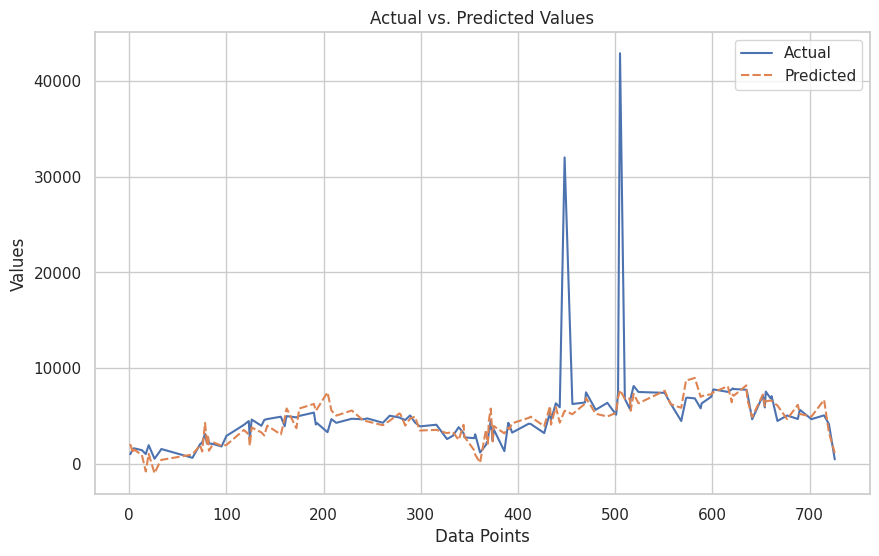

In [23]:
actual_vs_predicted(y_validate, y_pred)

Anhand der Performace Measures ist zu erkennen, dass sich durch diesen Schritt keine wesentlichen Verbesserungen ergeben haben.

## 5 Data Corrections

Aus der deskriptiven Statistik ist ersichltich, dass das Minimum der Variable `windspeed` bei `-1` liegt. 

Da die Windgeschwindigkeit nicht negativ sein kann, treffen wir die Annahme, dass es sich hierbei um Fehler handeln muss.

Hier würde sich ggf. eine Regression Imputation zum Auffüllen der vier fehlenden Werte anbieten.

Aus der Correlation Matrix sehen wir aber, dass `windspeed` kaum mit anderen Features korreliert. Aus diesem Grund entfernen wir die Werte.

Hierfür nutzen wir folgende Funktion, welche die negativen Werte einer Spalte dropt.

In [24]:
def drop_rows(df: pd.DataFrame, target: str, thresh: Union[int, float]) -> pd.DataFrame:
    """
    Drop rows based on a threshold.
    
    Args:
        df: pd.DataFrame: The DataFrame to be transformed.
        target: str: The target column.
        threshold: float: The threshold for dropping rows.

    Returns:
        pd.DataFrame: The transformed DataFrame.
    """
    try:
        df = df.loc[df[target] >= thresh]
        print(f"{df.shape[0]} rows remaining")
    except KeyError:
        print(f"{target} not found in DataFrame")
    return df

In [25]:
train_data = drop_rows(train_data, "windspeed", 0.0)

596 rows remaining


Nachdem die falschen Werte entfernt wurden, können wir die Daten wieder in `train` und `validate` Daten splitten.

In [26]:
X_train, X_validate, y_train, y_validate = train_test_split(train_data[features], train_data["cnt"], test_size=0.2, random_state=42)

In [27]:
def process_weekday(df: pd.DataFrame, target: str, date: str) -> pd.DataFrame:
    """
    Maps weekday based on date column values.
    
    Args:
        df (pd.DataFrame): DataFrame
        date (str): date column name (in datetime64 format)
    
    Returns:
        pd.DataFrame: DataFrame with 'weekday' column mapped based on date column values.
    """
    if date in df.columns:
        df[target] = (df[date].dt.dayofweek + 1) % 7

    return df

Wie im letzten Schritt definieren wir den `CustomTransformer`, um die Werte von `weekday` zu korrigieren.

In [28]:
weekday_by_date = CustomTransformer(function=process_weekday, config={"target": "weekday", "date": "dteday"})

data_correction_pipeline = Pipeline([
    ("feature_datetime", feature_datetime),
    ("season_imputer", season_imputer),
    ("weekday_by_date", weekday_by_date),
    ("numeric_values", numeric_values),
    ("imputer", SimpleImputer(strategy="mean")),
    ("baseline_model", baseline_model)])

TODO: remove warnings

In [29]:
data_correction_pipeline.fit(train_data[features], train_data["cnt"])

/tmp/ipykernel_1187242/208495991.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target] = pd.to_datetime(df[target], format=date_format)
/tmp/ipykernel_1187242/2224586021.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target] = df[date].apply(get_season)
/tmp/ipykernel_1187242/229000304.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

Pipeline(steps=[('feature_datetime',
                 CustomTransformer(config={'target': 'dteday'},
                                   function=<function feature_to_datetime at 0x7fa3e6df85e0>)),
                ('season_imputer',
                 CustomTransformer(config={'date': 'dteday',
                                           'target': 'season'},
                                   function=<function impute_season at 0x7fa3e6df8860>)),
                ('weekday_by_date',
                 CustomTransformer(config={'date': 'dteday',
                                           'target': 'weekday'},
                                   function=<function process_weekday at 0x7fa3e77851c0>)),
                ('numeric_values',
                 CustomTransformer(function=<function select_numeric at 0x7fa3eadf7060>)),
                ('imputer', SimpleImputer()),
                ('baseline_model',
                 Pipeline(steps=[('baseline_model', LinearRegression())]))])

In [30]:
y_pred = data_correction_pipeline.predict(X_validate)

In [31]:
_, _ = performance_measures(y_validate, y_pred)

R2: 0.31
MAE: 971.88


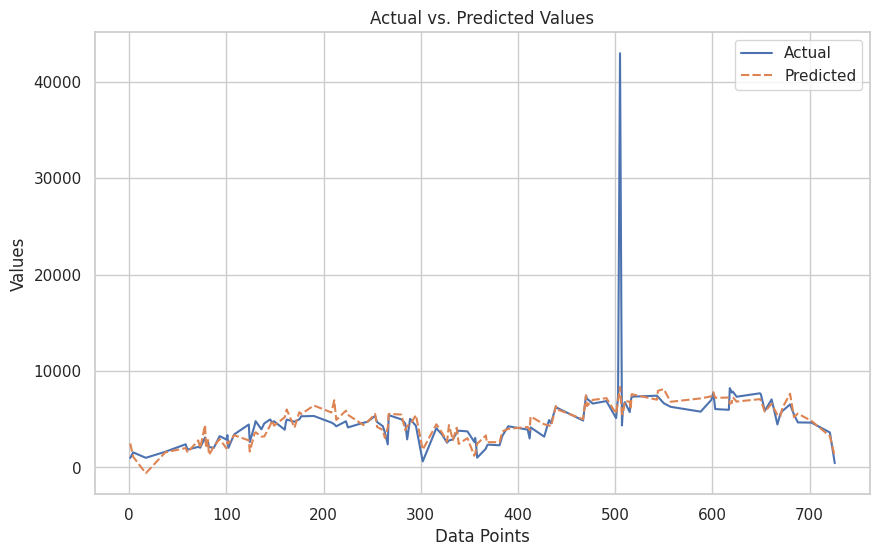

In [32]:
actual_vs_predicted(y_validate, y_pred)

Nachdem die Daten korregiert wurden, ist zu erkennen, dass einige Ausreißer mit den falschen Werten von `windspeed` entfernt wurden.

Zudem ist eine leichte Verbesserung in den Preformance Measures zu erkennen.

## 6 Outlier Handling

Es ist zu sehen, dass die Gesamtanzahl der geliehenen Fahrräder und die Anzahl der durch `casual` Nutzer geliehenen Fahrräder unrealistisch hohe Maximalwerte aufweisen.

In [33]:
train_data[['casual', 'cnt']].describe().T

,count,mean,std,min,25%,50%,75%,max
casual,596.0,1067.533557,2980.589711,2.0,310.0,709.5,1077.00,47138.0
cnt,596.0,4700.850671,3600.298417,22.0,3111.5,4510.0,5922.75,53021.0


Da `cnt` die Summe aus `casual` und `registered` ist, werden beim Entfernen der Outlier von `casual` auch die Outlier von `cnt` entfernt.

In [34]:
zscores = stats.zscore(train_data["casual"])
thresh = 3.0
outliers = train_data[abs(zscores) > thresh]
outliers

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,leaflets,price reduction,casual,registered,cnt
instant,,,,,,,,,,,,,,,,,
631,22.09.2012,3.0,1,9,0,6,0,1,26.0000,0.610488,97.00005,0.283583,963,0,47138,5883,53021
505,19.05.2012,2.0,1,5,0,6,0,1,24.0000,0.566908,68.43750,0.083975,1030,0,38061,4884,42945
448,23.03.2012,2.0,1,3,0,5,1,2,24.0667,0.570067,104.12505,0.116300,535,1,26150,5893,32043
624,15.09.2012,3.0,1,9,0,6,0,1,24.3333,0.585867,75.25005,0.247521,820,0,30378,5554,35932


Diese Werte werden auf Basis der zuvor berechneten `z-scores` entfernt.

In [35]:
train_data = train_data.drop(outliers.index, errors="ignore")

In [36]:
train_data[['casual', 'cnt']].describe().T

,count,mean,std,min,25%,50%,75%,max
casual,592.0,835.342905,681.859751,2.0,309.75,703.5,1070.00,3283.0
cnt,592.0,4455.685811,1910.194497,22.0,3089.00,4489.0,5879.25,8227.0


In [37]:
X_train, X_validate, y_train, y_validate = train_test_split(train_data[features], train_data["cnt"], test_size=0.2, random_state=42)

In [38]:
data_correction_pipeline = Pipeline([
    ("feature_datetime", feature_datetime),
    ("season_imputer", season_imputer),
    ("weekday_by_date", weekday_by_date),
    ("numeric_values", numeric_values),
    ("imputer", SimpleImputer(strategy="mean")),
    ("baseline_model", baseline_model)])

In [39]:
data_correction_pipeline.fit(train_data[features], train_data["cnt"])

/tmp/ipykernel_1187242/208495991.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target] = pd.to_datetime(df[target], format=date_format)
/tmp/ipykernel_1187242/2224586021.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target] = df[date].apply(get_season)
/tmp/ipykernel_1187242/229000304.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

Pipeline(steps=[('feature_datetime',
                 CustomTransformer(config={'target': 'dteday'},
                                   function=<function feature_to_datetime at 0x7fa3e6df85e0>)),
                ('season_imputer',
                 CustomTransformer(config={'date': 'dteday',
                                           'target': 'season'},
                                   function=<function impute_season at 0x7fa3e6df8860>)),
                ('weekday_by_date',
                 CustomTransformer(config={'date': 'dteday',
                                           'target': 'weekday'},
                                   function=<function process_weekday at 0x7fa3e77851c0>)),
                ('numeric_values',
                 CustomTransformer(function=<function select_numeric at 0x7fa3eadf7060>)),
                ('imputer', SimpleImputer()),
                ('baseline_model',
                 Pipeline(steps=[('baseline_model', LinearRegression())]))])

In [40]:
y_pred = data_correction_pipeline.predict(X_validate)

In [41]:
_, _ = performance_measures(y_validate, y_pred)

R2: 0.86
MAE: 602.33


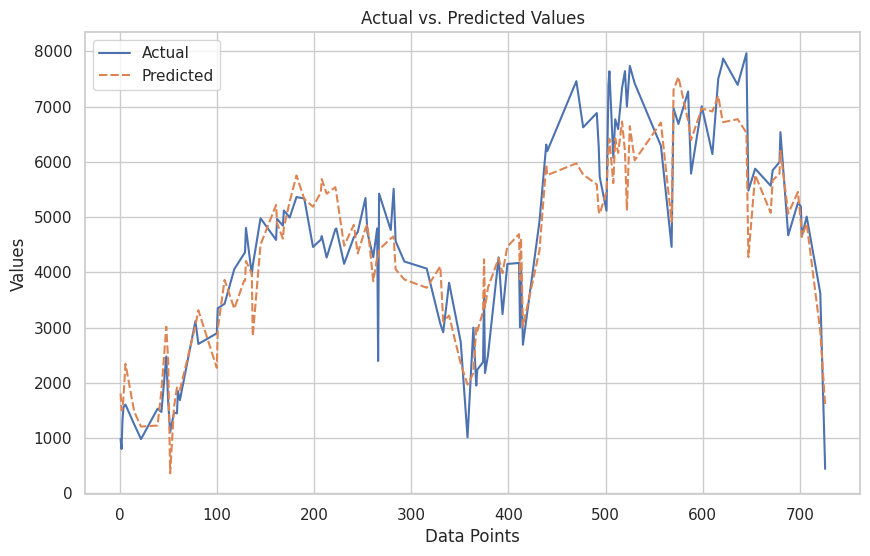

In [42]:
actual_vs_predicted(y_validate, y_pred)

Es ist zu erkennen, dass die Performace Measures, nach der Entfernung der Outliers, eine wesentliche Verbesserung zeigen.

## 7 Feature Transformation

In [43]:
X_train, X_validate, y_train, y_validate = train_test_split(train_data[features], train_data["cnt"], test_size=0.2, random_state=42)

### 7.1 One Hot Encoding

Für die Variablen `weekday`, `season` und `weathersit` erstellen wir mittels One Hot Encoding separate binäre Spalten für jede Ausprägung. 

Anschließend entfernen wir die ursprünglichen drei Spalten.

In [ ]:
data_correction_pipeline = Pipeline([
    ("feature_datetime", feature_datetime),
    ("season_imputer", season_imputer),
    ("weekday_by_date", weekday_by_date),
    ("numeric_values", numeric_values),
    ("one_hot_encoder", OneHotEncoder())
    ("imputer", SimpleImputer(strategy="mean")),
    ("baseline_model", baseline_model)])

In [44]:
data_d = pd.concat([data_no_out, pd.get_dummies(data_no_out["weekday"], prefix="weekday", dtype=int)], axis=1)
data_d = pd.concat([data_d, pd.get_dummies(data_no_out["season"], prefix="season", dtype=int)], axis=1)
data_d = pd.concat([data_d, pd.get_dummies(data_no_out["weathersit"], prefix="weathersit", dtype=int)], axis=1)
data_d.drop(columns=["weekday", "weathersit", "season"], inplace=True)

NameError: name 'data_no_out' is not defined

In [ ]:
data_d

In [ ]:
final_model = baseline_linreg(data_d)

### 7.2 Normalisierung 

In [ ]:
X_train, X_validate, y_train, y_validate = train_test_split(train_data[features], train_data["cnt"], test_size=0.2, random_state=42)

Zum anderen werden alle Features mit Hilfe eines ```StandardScalers``` normalisiert, um den Einfluss der Gewichtung einzelner Features, aufgrund ihrer Wertebereiche, zu eliminiern.
("scaler", StandardScaler())

## 8 Multicolinearity

In der Korrelationsmatrix ist zu sehen, dass die Variablen `hum` und `atemp`, und `temp` und `weathersit` eine starke Korrelation aufweisen. Dies kann später zu Problemen bei der Regression führen, daher werden nur `atemp` und `weathersit` behalten. Wir verwenden die gefühlte Temperatur, da diese zu einem Grad aus der tatasächlichen Temperatur und der Luftfeuchte hervorgeht.

In [ ]:
X_train, X_validate, y_train, y_validate = train_test_split(train_data[features], train_data["cnt"], test_size=0.2, random_state=42)

In [ ]:
#data_d.drop(columns=["hum", "temp"], inplace=True)
data_d.drop(columns=["temp"], inplace=True)

In [ ]:
baseline_linreg(data_d)

Zuletzt exportieren wir das Datenset als CSV und speichern das Model.

In [ ]:
data_d.to_csv(f"../data/prepared_{file_to_prepare}.csv", sep=";")

import pickle
filename = '../models/final_model.pkl'
pickle.dump(final_model, open(filename, 'wb'))
features = '../models/final_model_features.pkl'
pickle.dump(data_d.columns, open(features, 'wb'))

In [ ]:
data_d.describe().T

Jetzt laden wir die Test Daten um das Model damit zu evaluieren.

In [ ]:
test_data = pd.read_csv(f"../data/prepared_test.csv", sep=";", index_col=0)

final_model = pickle.load(open(filename, 'rb'))
final_model_features = pickle.load(open(features, 'rb'))

## 10 Task 2 - idstools ##

Parallel zu der schrittweisen Evaluierung des Baseline Models mit den Trainigsdaten, haben wir eine Pipeline erstellt, welche die einzelnen Schritte automatisiert ausführt.

Hierfür haben wir ein Framework entwickelt welches auf Basis von ```Target``` Objekten verschiedene Funktionen anwenden kann.

Im ersten Schritt initialisieren wir die beiden ```Target```Objekte für den Trainings- und Testdatenstatz. 

In [ ]:
train_target = Target(
    id=1,
    input_path="data/BikeRentalDaily_train.csv",
    input_delimiter=";",
    label="cnt"
)
test_target = Target(
    id=2,
    input_path="data/BikeRentalDaily_test.csv",
    input_delimiter=";",
    label="cnt"
)

Danach laden wir die Konfiguration für Task 2.

In [ ]:
config = load_config('../config/idstools/Task_2.yaml')

In dieser Konfiguration sind die beiden Pipelines für das Preprocessing und die anschließende Model Evaluierung enthalten.'

In [ ]:
config

Im zweiten Schritt initialisieren wir das ```preparation``` Objekt. Diesem werden einerseites die beiden Training und Test Targets und andererseteits die Konfiguration der Preprocessing-Pipeline übergeben.

In [ ]:
preparation = DataPreparation(targets=[train_target, test_target], pipeline=config.preprocessing.pipeline)

Die Preprocessing-Schritte werden durch aufrufen der ```run``` Methode auf die beiden Targets angewendet. 

In [ ]:
preparation.run()

Im dritten und letzten Schritt wird das ```optimization``` Objekt initialisiert. Diesem werden wie im vorhergehenden Schritt die Targets und die Konfiguration der Evaluation-Pipeline übergeben.

In [ ]:
optimization = ModelOptimization(targets=[train_target, test_target], pipeline=config.optimization.pipeline)

Die Evaluierung der in der Pipeline definierten Modelle, sowie Data splitting und anwenden der konfigurierten Validierungsmethoden werden durch ausführen der ```run``` Methode durchgeführt. 

Die Ergebnisse der Validierung werden im Target-Objekt gespeichert.

In [ ]:
optimization.run()

Das Folgende Diagramm zeigt die Performance des Baseline Modells nach anwenden der Preprocessing Pipeline auf Basis der Testdaten in Form eines Liniendiagramms.

In [ ]:
test_target.figures[1]['Actual_vs_Predicted']